In [1]:
import tensorflow

print(tensorflow.__version__)

2.6.0


In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

import os
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 197463


,eng,fra,cc
87119,I don't know if I can stay.,Je ne sais pas si je peux rester.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
192777,"As soon as I can afford it, I plan to travel a...","Dès que j'en ai les moyens, je prévois de voya...",CC-BY 2.0 (France) Attribution: tatoeba.org #9...
132523,They wouldn't have done anything.,Ils n'auraient rien fait.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
175143,He is as smart as any other boy in the class.,Il est aussi intelligent que n'importe quel au...,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
106276,"Tom is left-handed, isn't he?","Tom est gaucher, n'est-ce pas ?",CC-BY 2.0 (France) Attribution: tatoeba.org #6...


In [3]:
lines = lines[['eng', 'fra']][:50000] # 5만개 샘플 사용
lines.sample(5)

,eng,fra
14617,I won the fight.,J'ai gagné le combat.
14403,I often do that.,Je le fais beaucoup.
43135,I thought you'd left.,Je pensais que vous étiez partis.
2073,I was good.,J'ai été bon.
21057,Tom is coming to.,Tom reprend conscience.


Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)

In [4]:
PUNCTUATION_REGEX = r'''[!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]'''
lines["eng"] = lines["eng"].str.replace(PUNCTUATION_REGEX, r' \g<0> ', regex=True)
lines["fra"] = lines["fra"].str.replace(PUNCTUATION_REGEX, r' \g<0> ', regex=True)
lines['eng'] = lines['eng'].str.rstrip()
lines['fra'] = lines['fra'].str.rstrip()
lines['eng'] = lines['eng'].str.lower()
lines['fra'] = lines['fra'].str.lower()

Step 2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.

In [5]:
# 시작 토큰과 종료 토큰 추가
sos_token = '\t'
eos_token = '\n'
lines.fra = lines.fra.apply(lambda x : '\t '+ x + ' \n')
print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 50000


,eng,fra
49831,i know a lot about it .,\t j ' en sais beaucoup à ce sujet . \n
32878,tom was distressed .,\t tom était secoué . \n
8056,it ' s a weapon .,\t il s ' agit d ' une arme . \n
15410,my suit is gray .,\t mon costume est gris . \n
38603,they ' re all waiting .,\t ils sont tous en train d ' attendre . \n


Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.

In [6]:
eng_tokenizer = Tokenizer(filters = ' ') 
eng_tokenizer.fit_on_texts(lines.eng)              
input_text = eng_tokenizer.texts_to_sequences(lines.eng)  
input_text[:3]

[[34, 1], [34, 1], [34, 1]]

In [7]:
fra_tokenizer = Tokenizer(filters = ' ')   # 문자 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(lines.fra)                 
target_text = fra_tokenizer.texts_to_sequences(lines.fra)     
target_text[:3]

[[1, 92, 15, 2], [1, 437, 3, 2], [1, 30, 603, 15, 2]]

In [8]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 6042
프랑스어 단어장의 크기 : 12207


In [9]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 10
프랑스어 시퀀스의 최대 길이 20


In [10]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 50000
영어 단어장의 크기 : 6042
프랑스어 단어장의 크기 : 12207
영어 시퀀스의 최대 길이 10
프랑스어 시퀀스의 최대 길이 20


In [11]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [12]:
print(decoder_input[:3])
print(decoder_target[:3])

[[1, 92, 15], [1, 437, 3], [1, 30, 603, 15]]
[[92, 15, 2], [437, 3, 2], [30, 603, 15, 2]]


In [13]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (50000, 10)
프랑스어 입력데이터의 크기(shape) : (50000, 20)
프랑스어 출력데이터의 크기(shape) : (50000, 20)


In [14]:
print(encoder_input[0])

[34  1  0  0  0  0  0  0  0  0]


In [15]:
# encoder_input = to_categorical(encoder_input)
# decoder_input = to_categorical(decoder_input)
# decoder_target = to_categorical(decoder_target)
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (50000, 10)
프랑스어 입력데이터의 크기(shape) : (50000, 20)
프랑스어 출력데이터의 크기(shape) : (50000, 20)


In [16]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (50000, 10)
프랑스어 학습 입력데이터의 크기(shape) : (50000, 20)
프랑스어 학습 출력데이터의 크기(shape) : (50000, 20)


Step 4. 임베딩 층(Embedding layer) 사용하기

In [17]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

# 입력 텐서 생성.
encoder_inputs = Input(shape=(None, ))
enc_emb =  Embedding(fra_vocab_size, output_dim = 128)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb)
encoder_lstm = LSTM(units = 128, return_state = True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
encoder_states = [state_h, state_c]

In [18]:
# 인코더에서 사용할 임베딩 층 사용 예시
decoder_inputs = Input(shape=(None,))
dec_emb_layer =  Embedding(fra_vocab_size, output_dim = 128)
dec_emb = dec_emb_layer(decoder_inputs)
dec_masking = Masking(mask_value=0.0)(dec_emb)
decoder_lstm = LSTM(units = 128, return_sequences = True, return_state=True)
decoder_outputs, _, _= decoder_lstm(dec_masking, initial_state = encoder_states)

decoder_softmax_layer =Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

Step 5. 모델 구현하기

In [19]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 128)    1562496     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    1562496     input_2[0][0]                    
______________________________________________________________________________________________

In [20]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

tf.random.set_seed(2)

opt = RMSprop(learning_rate=0.0001)
model.compile(opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=30)

Epoch 1/30
368/368 [==============================] - 24s 45ms/step - loss: 5.3248 - accuracy: 0.6469 - val_loss: 2.8622 - val_accuracy: 0.5932
Epoch 2/30
368/368 [==============================] - 14s 39ms/step - loss: 2.0569 - accuracy: 0.6540 - val_loss: 2.2522 - val_accuracy: 0.5932
Epoch 3/30
368/368 [==============================] - 14s 39ms/step - loss: 1.7276 - accuracy: 0.7007 - val_loss: 2.0354 - val_accuracy: 0.6821
Epoch 4/30
368/368 [==============================] - 14s 39ms/step - loss: 1.5670 - accuracy: 0.7607 - val_loss: 1.9097 - val_accuracy: 0.6988
Epoch 5/30
368/368 [==============================] - 15s 39ms/step - loss: 1.4656 - accuracy: 0.7669 - val_loss: 1.8186 - val_accuracy: 0.7077
Epoch 6/30
368/368 [==============================] - 14s 39ms/step - loss: 1.3947 - accuracy: 0.7788 - val_loss: 1.7506 - val_accuracy: 0.7262
Epoch 7/30
368/368 [==============================] - 14s 39ms/step - loss: 1.3384 - accuracy: 0.7898 - val_loss: 1.6967 - val_accuracy:

Step 6. 모델 평가하기

In [21]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         1562496   
_________________________________________________________________
masking (Masking)            (None, None, 128)         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 128), (None, 128) 131584    
Total params: 1,694,080
Trainable params: 1,694,080
Non-trainable params: 0
_________________________________________________________________


In [22]:
decoder_state_input_h = Input(shape=(128,))
decoder_state_input_c = Input(shape=(128,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states2 = [state_h2, state_c2]

In [23]:
decoder_outputs2 = decoder_softmax_layer(decoder_outputs2)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs2] + decoder_states2)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    1562496     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128)]        0                                            
____________________________________________________________________________________________

In [24]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [25]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # 에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = fra2idx['\t']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # 에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [26]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + idx2eng[i]+' '
    return temp

In [27]:
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=fra2idx['<start>']) and i!=fra2idx['<end>']):
            temp = temp + idx2fra[i] + ' '
    return temp

In [28]:
import numpy as np
for seq_index in [7,58,445,534,985]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][1:len(lines.fra[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: run !
정답 문장:  courez  ! 
번역기가 번역한 문장:  ! 
-----------------------------------
입력 문장: oh no !
정답 문장:  oh non  ! 
번역기가 번역한 문장:  quelle n ' est - vou
-----------------------------------
입력 문장: you win .
정답 문장:  vous avez gagné . 
번역기가 번역한 문장:  vous avez l ' air . 
-----------------------------------
입력 문장: get lost .
정답 문장:  fiche le camp . 
번역기가 번역한 문장:  soyez ! 
-----------------------------------
입력 문장: hands off .
정답 문장:  ne touche pas à ça  ! 
번역기가 번역한 문장:  arrête - toi . 


In [29]:
history_dict = history.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


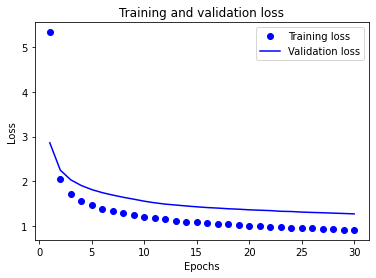

In [30]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

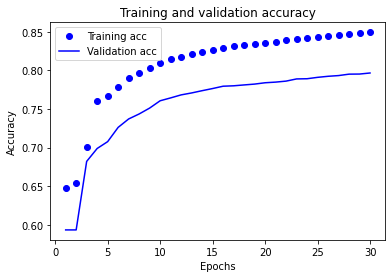

In [31]:
plt.clf()  
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

*번역 결과*

In [32]:
# -----------------------------------
# 입력 문장: run ! (달려!)
# 정답 문장:  courez  !  (달려!)
# 번역기가 번역한 문장:  soyez ! (어서!)
# -----------------------------------
# 입력 문장: oh no ! (안돼!)
# 정답 문장:  oh non  !  (안돼!)
# 번역기가 번역한 문장:  quelle êtes !  (뭐야!)
# -----------------------------------
# 입력 문장: you win . (너가 이겼다.)
# 정답 문장:  vous avez gagné . (당신이 이겼습니다.)
# 번역기가 번역한 문장:  tu es .  (너는 대단하구나.)
# -----------------------------------
# 입력 문장: get lost . (꺼져)
# 정답 문장:  fiche le camp . (꺼져라)
# 번역기가 번역한 문장:  laisse - toi ! (그만둬!)
# -----------------------------------
# 입력 문장: hands off . (손을 대지 마시오.)
# 정답 문장:  ne touche pas à ça  !  (손대지 마!)
# 번역기가 번역한 문장:  arrête de le . (그만 해라.)

In [33]:
#회고
# - 이번 프로젝트에서 어려웠던 점
# : 구두점을 토크나이저로 나누는게 참 어려웠다.
# - 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
# : eng_tokenizer = Tokenizer(filters = ' ')를 통해 문자를 ' ' 단위로 자를 수 있다.
# - 루브릭 평가 지표를 맞추기 위해 시도한 것들:
# : PUNCTUATION_REGEX = r'''[!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]'''
# lines["eng"] = lines["eng"].str.replace(PUNCTUATION_REGEX, r' \g<0> ', regex=True)
# lines["fra"] = lines["fra"].str.replace(PUNCTUATION_REGEX, r' \g<0> ', regex=True)
# lines['eng'] = lines['eng'].str.rstrip()
# lines['fra'] = lines['fra'].str.rstrip()
# lines['eng'] = lines['eng'].str.lower()
# lines['fra'] = lines['fra'].str.lower()
# - 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정:
# : 달성했다.
# - 자기 다짐:
# : 오늘도 잔다고 못낼 것 같아 새벽에 미리 적는다.... ex3 못낸게 너무 아쉽다.